In [1]:
import numpy as np
import matplotlib.pyplot as plt

# create Layer class
class Layer:

    # intialize variables in class
    def __init__(self):
        self.input  = None
        self.output = None
        
    def feed_forward(self, input):
        pass      
    def backpropagation(self, op_error, alpha):
        pass

In [2]:
class LinearLayer(Layer):
    def __init__(self, ip_size, op_size, weights_size=0.5):
        super().__init__()
        
   
        if weights_size == None:
            self.weights = np.zeros((ip_size,op_size))
            self.bias = np.zeros((1,op_size))
      
        elif weights_size == 10:
            self.weights = np.random.uniform(-10,10, size=(ip_size,op_size))
            self.bias = np.random.uniform(1, op_size) 
    
        elif weights_size == 0.5:
            self.weights = np.random.rand(ip_size, op_size) - 0.5
            self.bias = np.random.rand(1, op_size) - 0.5

   
    def feed_forward(self, ip_data):
        self.input = ip_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output


    def backpropagation(self, op_error, alpha):
        ip_error = np.dot(op_error, self.weights.T)
        weights_error = np.dot(self.input.T, op_error)
        

        self.weights -= alpha * weights_error
        self.bias -= alpha * op_error
        return ip_error

In [3]:
class SigmoidLayer(Layer):
    def __init__(self):
        super().__init__()

    def feed_forward(self, ip_data):
        self.input = ip_data
        self.output = 1 / (1 + np.exp(-self.input))
        return self.output

    def backpropagation(self, op_error, alpha):
        return np.exp(-self.input) / ((1 + np.exp(-self.input)) ** 2) * op_error

In [4]:
class HyperbolidTangentLayer(Layer):
    def __init__(self):
        super().__init__()

    def feed_forward(self, ip_data):
        self.input = ip_data
        self.output = np.tanh(self.input)
        return self.output

    def backpropagation(self, op_error, alpha):
        return (1 - np.tanh(self.input) ** 2) * op_error

In [5]:
class SoftmaxLayer(Layer):
    def __init__(self, ip_size):
        super().__init__()
        self.ip_size = ip_size
    
    def feed_forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backpropagation(self, op_error, alpha):
        ip_error = np.zeros(op_error.shape)
        out = np.tile(self.output.T, self.ip_size)
        return self.output * np.dot(op_error, np.identity(self.ip_size) - out)

In [6]:

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true

def categorical_cross_entropy_loss(target, predictions):
    return -np.sum(target * np.log(predictions))

def categorical_cross_entropy_grad(target, predictions):
    return predictions - target

In [7]:
class Network:
    def __init__(self):
        self.hidden_layers = []
        self.loss = None
        self.loss_prime = None
        self.err = []


    def add(self, layer):
        self.hidden_layers.append(layer)

    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, ip_data, prob=False):
        samples = len(ip_data)
        result = []
        y_pred = []


        for i in range(samples):
            output = ip_data[i]
            for layer in self.hidden_layers:
                output = layer.feed_forward(output)
            result.append(output)
        if prob:
            return result
            
        if len(result[0][0])==1:
            for i in result:
                if abs(i[0][0]) >= 0.5:
                    y_pred.append(1)
                else:
                    y_pred.append(0) 
            return np.array(y_pred)
        for val in result:
            y_pred.append(np.argmax(val[0], axis = 0))
        return np.array(y_pred)


    def fit(self, x_train, y_train, step_count, alpha):
        samples = len(x_train)

        for i in range(step_count):
            err = 0
            for j in range(samples):
                output = x_train[j]
                for layer in self.hidden_layers:
                    output = layer.feed_forward(output)

                err += self.loss(y_train[j], output)

                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.hidden_layers):
                    error = layer.backpropagation(error, alpha)
 
            err /= samples
            self.err.append(err)

            
    def accuracy(self,y_pred, y_output):
        return np.mean(y_pred == y_output)
    
    def plot(self, lr):
        plt.figure(figsize=(15,5))
        plt.plot(self.err, '--r')
        plt.title("Loss vs Step Count (Alpha = {0})".format(lr))
        plt.xlabel("Step Count")
        plt.ylabel("loss")
        plt.show()

In [8]:
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

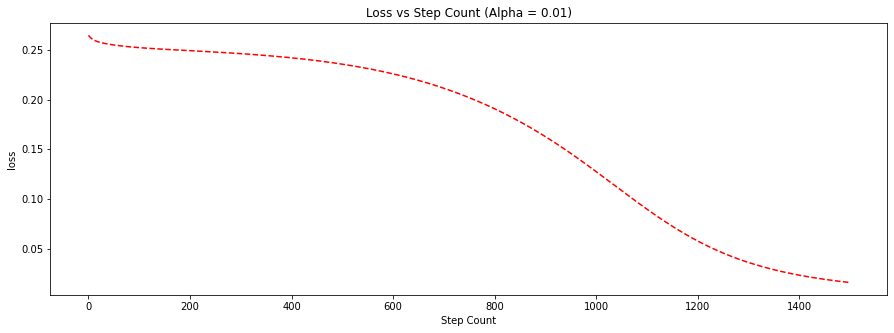

Accuracy : 100.0 %


In [9]:
xor_network = Network()
xor_network.add(LinearLayer(2, 3, weights_size=0.5))
xor_network.add(HyperbolidTangentLayer())
xor_network.add(LinearLayer(3, 1, weights_size=0.5))
xor_network.add(HyperbolidTangentLayer())

xor_network.use(mse, mse_prime)
lr = 0.01
xor_network.fit(x_train, y_train, step_count=1500, alpha=lr)

xor_network.plot(lr)

y_pred= xor_network.predict(x_train)
print("Accuracy :", xor_network.accuracy(y_pred, y_train.reshape(1,-1)[0])*100,"%")

In [10]:
import pickle

with open('xor_network.pkl', 'wb') as output_file:
    pickle.dump(xor_network, output_file, pickle.HIGHEST_PROTOCOL)

with open('xor_network.pkl', 'rb') as input_file:
    reloaded_model = pickle.load(input_file)

y_pred = reloaded_model.predict(x_train)
print("Accuracy for reloaded model :", xor_network.accuracy(y_pred, y_train.reshape(1,-1)[0])*100,"%")

Accuracy for reloaded model : 100.0 %


In [11]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255

y_train =  get_one_hot(y_train.astype(int), 10)

x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test =  get_one_hot(y_test.astype(int), 10)

def testing_images(model, samples=10):
    for test, true in zip(x_test[:samples], y_test[:samples]):
        image = np.reshape(test, (28, 28))
        plt.imshow(image, cmap='binary')
        pred = model.predict(test)
        idx_true = np.argmax(true)
        plt.title('prediction: {0}, output: {1}'.format(pred[0], idx_true))
        plt.show()

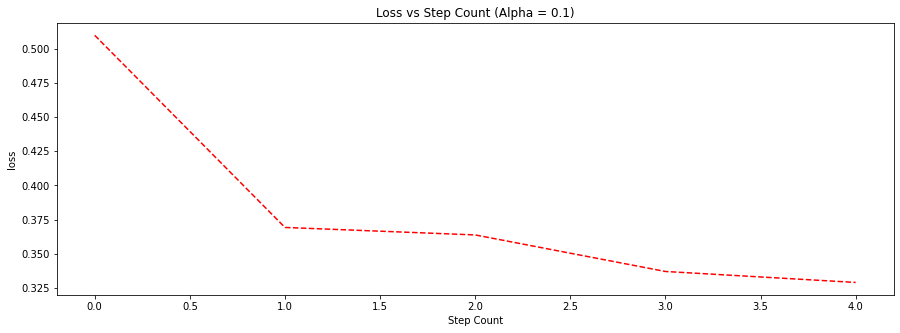

Accuracy For Model 1: (94.84) %


In [12]:
model_1 = Network()
model_1.add(LinearLayer(28*28, 100, weights_size=0.5))     
model_1.add(HyperbolidTangentLayer())
model_1.add(LinearLayer(100, 10, weights_size=0.5)) 
model_1.add(SoftmaxLayer(10))

model_1.use(categorical_cross_entropy_loss, categorical_cross_entropy_grad)
lr = 0.1
model_1.fit(x_train, y_train, step_count=5, alpha=lr)

model_1.plot(lr)

y_pred = model_1.predict(x_test)
print("Accuracy For Model 1: ({0}) %".format(round(model_1.accuracy(y_pred, np.argmax(y_test, axis = 1))*100,2)))

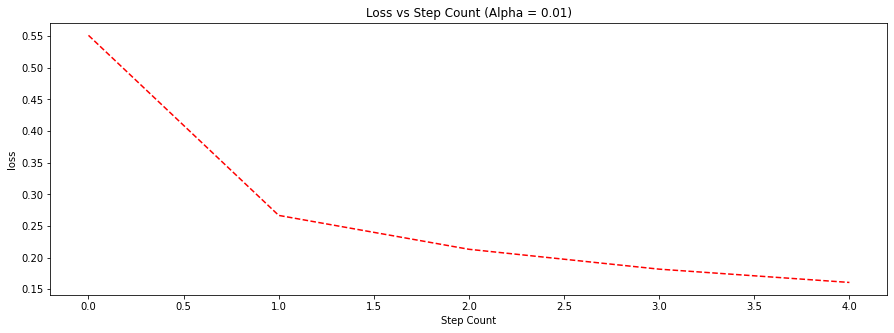

Accuracy For Model 2: (94.42) %


In [13]:
model_2 = Network()
model_2.add(LinearLayer(28*28, 100, weights_size=0.5))     
model_2.add(HyperbolidTangentLayer())
model_2.add(LinearLayer(100, 50, weights_size=0.5))  
model_2.add(HyperbolidTangentLayer())
model_2.add(LinearLayer(50, 10, weights_size=0.5)) 
model_2.add(SoftmaxLayer(10))

model_2.use(categorical_cross_entropy_loss, categorical_cross_entropy_grad)
lr = 0.01
model_2.fit(x_train, y_train, step_count=5, alpha=lr)

model_2.plot(lr)

y_pred = model_2.predict(x_test)
print("Accuracy For Model 2: ({0}) %".format(round(model_2.accuracy(y_pred, np.argmax(y_test, axis = 1))*100,2)))

In [ ]:
model_3 = Network()
model_3.add(LinearLayer(28*28, 100, weights_size=0.5))     
model_3.add(HyperbolidTangentLayer())
model_3.add(LinearLayer(100, 50, weights_size=0.5))  
model_3.add(HyperbolidTangentLayer())
model_3.add(LinearLayer(50, 30, weights_size=0.5))  
model_3.add(HyperbolidTangentLayer())
model_3.add(LinearLayer(30, 10, weights_size=0.5)) 
model_3.add(SoftmaxLayer(10))

model_3.use(categorical_cross_entropy_loss, categorical_cross_entropy_grad)
lr = 0.001
model_3.fit(x_train, y_train, step_count=5, alpha=lr)

model_3.plot(lr)

y_pred = model_3.predict(x_test)
print("Accuracy For Model 3: ({0}) %".format(round(model_3.accuracy(y_pred, np.argmax(y_test, axis = 1))*100,2)))

In [ ]:
exp_1 = Network()
exp_1.add(LinearLayer(28*28, 100, weights_size=None))     
exp_1.add(HyperbolidTangentLayer())
exp_1.add(LinearLayer(100, 10, weights_size=None)) 
exp_1.add(SoftmaxLayer(10))

exp_1.use(categorical_cross_entropy_loss, categorical_cross_entropy_grad)
lr = 1
exp_1.fit(x_train, y_train, step_count=5, alpha=lr)

exp_1.plot(lr)

y_pred = exp_1.predict(x_test)
print("Accuracy For Experimental Model 1: ({0}) %".format(round(exp_1.accuracy(y_pred, np.argmax(y_test, axis = 1))*100,2)))

In [ ]:
exp_2 = Network()
exp_2.add(LinearLayer(28*28, 100, weights_size=10))     
exp_2.add(SigmoidLayer())
exp_2.add(LinearLayer(100, 10, weights_size=10)) 
exp_2.add(SoftmaxLayer(10))

exp_2.use(categorical_cross_entropy_loss, categorical_cross_entropy_grad)
lr = 0.001
exp_2.fit(x_train, y_train, step_count=5, alpha=lr)

exp_2.plot(lr)

y_pred = exp_2.predict(x_test)
print("Accuracy For Experimental Model 2: ({0}) %".format(round(exp_2.accuracy(y_pred, np.argmax(y_test, axis = 1))*100,2)))